## set up workspace

In [2]:
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
sns.set_style('whitegrid')

from covid_model_deaths.preprocessing import expanding_moving_average_by_location

pd.options.display.max_rows = 99
pd.options.display.max_columns = 99
warnings.simplefilter('ignore')


## define smoother

In [3]:
def add_moving_average(data: pd.DataFrame, smoooth_var: str,
                       rate_threshold: float, n_smooths: int) -> pd.DataFrame:
    """Smooths over the log age specific death rate.

    Parameters
    ----------
    data
        The data with the age specific death rate to smooth over.
    rate_threshold
        The minimum age specific death rate.  Values produced in the
        averaging will be pinned to this.

    Returns
    -------
        The same data with the log asdr replaced with its average and a new
        column with the original observed asdr.

    """
    required_columns = ['location_id', 'Date', 'Days', smoooth_var]
    assert set(required_columns).issubset(data.columns)
    data[f'Observed {smoooth_var}'] = data[smoooth_var]
    # smooth n times
    for i in range(n_smooths):
        moving_average = expanding_moving_average_by_location(data, smoooth_var)
        # noinspection PyTypeChecker
        moving_average[moving_average < rate_threshold] = rate_threshold
        data = data.set_index(['location_id', 'Date'])
        data = (pd.concat([data.drop(columns=smoooth_var), moving_average], axis=1)
                .fillna(method='pad')
                .reset_index())

    return data


## load data and smooth

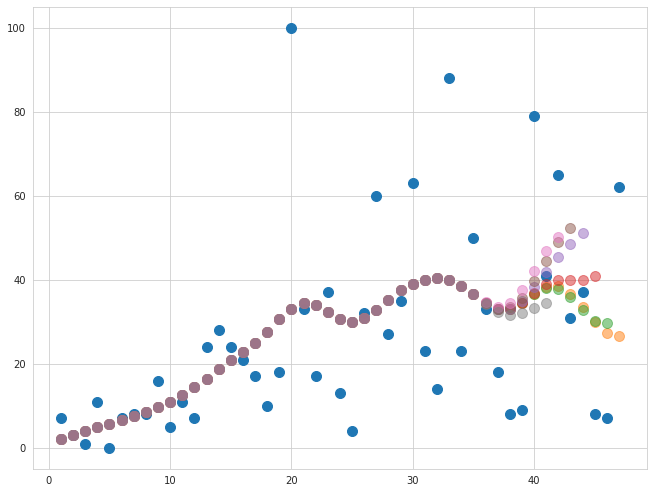

In [86]:
plot_loc = 533
df = pd.read_csv('/ihme/covid-19/model-inputs/best/deaths.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['ln(death rate)'] = np.log(df['Death rate'])
# df = df.loc[df['Country/Region'] == 'United States of America']
# df = df.loc[df['location_id'] != 102]
df = df.loc[df['location_id'].isin([plot_loc, 553])].reset_index(drop=True)
df['max_days'] = df.groupby('location_id', as_index=False).Days.transform(max)

plt.figure(figsize=(11, 8.5))
plt.scatter(df.loc[df['location_id'] == plot_loc, 'Days'][1:], 
            df.loc[df['location_id'] == plot_loc, 'Deaths'].values[1:] - \
            df.loc[df['location_id'] == plot_loc, 'Deaths'].values[:-1],
            s=100)
for n_drop in range(7):
    smooth_df = add_moving_average(df.loc[df['Days'] <= df['max_days'] - n_drop], 'ln(death rate)', -np.inf, 10)
    smooth_df = smooth_df.loc[smooth_df['location_id'] == plot_loc]
    smooth_df['Deaths'] = np.exp(smooth_df['ln(death rate)']) * smooth_df['population']
    plt.scatter(smooth_df['Days'][1:], 
                smooth_df['Deaths'].values[1:] - smooth_df['Deaths'].values[:-1],
                s=100, alpha=0.5)
plt.show()
